In [12]:
%matplotlib inline

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import numpy.matlib
import cv2
from skimage import io
import sys
from scipy import ndimage, signal
from random import randint, gauss
import math
from skimage.color import rgba2rgb, rgb2gray

<Figure size 432x288 with 0 Axes>

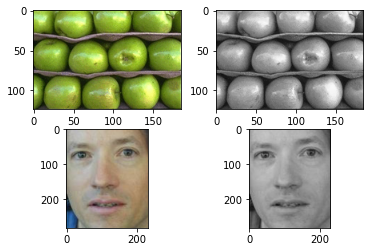

In [13]:
# pre-process the images
apples = image.imread('../images/apples.png')
bill = image.imread('../images/bill.png')

# remove the alpha channel
a = rgba2rgb(apples)
# convert the images' colormap to gray
inputTexture = rgb2gray(a)   
inputTarget = rgb2gray(bill)  

# display the processed images
plt.figure()
fig, arr = plt.subplots(2,2) 

arr[0,0].imshow(a)
arr[0,1].imshow(inputTexture, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
arr[1,0].imshow(bill)
arr[1,1].imshow(inputTarget, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [14]:
[m, n] = inputTarget.shape

mask_in = inputTexture<-1;
mask_out = inputTarget<-1;

inputTexture[mask_in] = -1;
inputTarget[mask_out] = -1;

In [15]:
# PSEUDO: Pick size of block and size of overlap
# the values are taken from the MATLAB implementation

w = 8
al = 0.43;
o = round(w/3);
m1 = math.floor((m-o)/w)*w+o;
n1 = math.floor((n-o)/w)*w+o;

outputTexture = np.zeros([m,n])
outputTexture1 = np.zeros([m,n,3])
itera = 2

In [16]:
# find the minimum error boundary to reduce the blockiness
# minimum error is computed as a minimum cost path through the error surface at the overlap
def findBoundaryHelper1(error):
    x, y = error.shape[0], error.shape[1] 
    path = np.zeros([x, y])
    cost = np.zeros([x, y])
    cost[x-1,:] = error[x-1,:]
    for i in range(x-2, 0, -1):
        mintree = np.array([np.append(float('+inf'), cost[i,0:y-1]), cost[i,:], np.append(cost[i,1:y], float('+inf'))], dtype=object)+ error[i-1,:] 
        cost[i,:] = np.min(mintree, axis = 0)
        path[i,:] = np.argmin(mintree, axis=0)
    np.where(path==1, path, 0)
    np.where(path==0, path, -1)
    np.where(path==2, path, 1)
    return cost, path

In [17]:
# declare the minimum cost path to be the boundary of the new block
def findBoundaryHelper2(path, ind):
    m = path.shape[1]
    boundary = np.zeros([path.shape[0], path.shape[1]])
    boundary[0,0:ind] = 1
    prev = ind - 1
    for i in range(1, m-1):
        prev = prev + path[i, int(prev)]
        boundary[i, 0:int(prev)] = 1
    return boundary

In [18]:
# find the nearest patch (grayscale, color)
def givePatch(al, a, inputTexture, inputTarget, temp1,mask):
    temp2 = np.linalg.multi_dot([temp1,temp1,mask])
    temp3 = np.multiply(inputTexture, inputTexture)
    temp3 = signal.convolve2d(temp3, np.rot90(mask, 2), mode='valid')
    temp4 = signal.convolve2d(inputTexture, np.rot90(np.multiply(temp1, mask), 2), mode='valid')

    temp5 = np.multiply(inputTarget, inputTarget)
    m1 = np.ones([mask.shape[0], mask.shape[1]])
    
    temp6 = signal.convolve2d(np.multiply(inputTexture, inputTexture), np.rot90(m1, 2), mode='valid')
    temp7 = signal.convolve2d(inputTexture, np.rot90(inputTarget, 2), mode='valid')

    errors = al*(np.sum(temp2)+temp3-2*temp4) + (1-al)* (np.sum(temp5)+temp6-2*temp7)
    minerror = abs(np.min(errors))
    [x,y] = np.where(errors <= minerror*1.3)
    randInt = randint(0, len(x))
    [m,n] = mask.shape;
    nearPatch = inputTexture[x[randInt]:x[randInt]+m,y[randInt]:y[randInt]+n]
    nearPatch1 = a[x[randInt]:x[randInt]+m,y[randInt]:y[randInt]+n,:]
    return nearPatch, nearPatch1

In [19]:
# PSEUDO: synthesize blocks in raster order
for p in range(0, itera):
    # loop over the number of patches - vertically
    for i in range(0, math.floor(m1/w)):
        # loop over the number of patches - horizontally
        for j in range(0, math.floor(n1/w)):
            if(np.all(np.all(mask_out[i*w:(i+1)*w+o,j*w:(j+1)*w+o]))):
                outputTexture[0:w+o,0:w+o] = 0
                outputTexture1[0:w+o,0:w+o] = 0
                continue
            # create a mask to check the overlaps later
            mask = np.zeros([w+o,w+o]);
            # nth patch
            temp1 = outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] 
            # 1st patch
            if(i==0 and j == 0):
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                outputTexture[0:w+o,0:w+o] = nearPatch
                outputTexture1[0:w+o,0:w+o,:] = nearPatch1
                continue
                
            # PSEUDO: search input texture for block that satisfies overlap constraints(above and left)
            # any patches in the first row other than the very first patch
            elif(i==0):
                # overlapped part is covered by the previous patch
                mask[:,0:o] = 1
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                
                # square the error; check if the near patch and the current patch look alike
                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                error = error[:,0:o]

                [cost,path] = findBoundaryHelper1(error)
                boundary = np.zeros([w+o, w+o])
                ind = int(np.argmin(cost[0,:]))
                boundary[:,0:o] = findBoundaryHelper2(path, ind)

            # PSEUDO: search input texture for block that satisfies overlap constraints(above and left)
            # any patches in the first column other than the very first patch
            elif(j==0):
                # overlapped part is covered by the previous patch
                mask[0:o,:] = 1
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                
                # square the error; check if the near patch and the current patch look alike
                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                error = error[0:o,:]
                [cost,path] = findBoundaryHelper1(error.T)
                boundary = np.zeros([w+o,w+o])
                ind = int(np.argmin(cost[0,:]))
                boundary[0:o,:] = (findBoundaryHelper2(path,ind)).T
            else:
                # overlapped parts are covered by the previous patch
                mask[:,0:o] = 1;
                mask[0:o,:] = 1;

                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                
                # square the error; check if the near patch and the current patch look alike
                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                
                # since the patch is neighboring with other synthesized patches, we need to consider both sides of boundaries
                error1 = error[0:o,:]
                error2 = error[:,0:o]

                [cost1,path1] = findBoundaryHelper1(error1.T)
                [cost2,path2] = findBoundaryHelper1(error2)

                cost = np.add(cost1[0:o,:], cost2[0:o,:])
                boundary =  np.zeros([w+o,w+o])

                ind = int(np.argmin(np.diag(cost)))
                # declare the minimum cost path to be the boundary of the new block
                boundary[0:o,ind:w+o] = (findBoundaryHelper2(path1[ind:o+w,:],o-ind)).T
                boundary[ind:o+w,0:o] = findBoundaryHelper2(path2[ind:o+w,:], ind)

                boundary[0:ind,0:ind] = 1
                
            # 4. paste new block into resulting texture- use dynamic programming to compute minimal error boundary cut
            smoothBoundary = boundary.T
            # create a color version of boundary
            smoothBoundary1 = numpy.repeat(boundary[:, :, np.newaxis], 3, axis=2)
            # 1- is needed since it is a grayscale image
            temp2 = np.multiply(temp1, smoothBoundary) + np.multiply(nearPatch, (1-smoothBoundary))
            outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] = temp2
            outputTexture1[i*w:(i+1)*w+o,j*w:(j+1)*w+o,:] = np.multiply(outputTexture1[i*w:(i+1)*w+o, j*w:(j+1)*w+o,:], smoothBoundary1) + np.multiply(nearPatch1, (1-smoothBoundary1))
    output = outputTexture1[0:m,0:n,:]
    output[numpy.repeat(mask_out[:, :, np.newaxis], 3, axis=2)] = 0
 
    w = round(w*0.7);
    o = round(w/3);
    if(itera > 1):
        al = 0.8*(p-1)/(iter-1)+0.1;
    else:
        continue;
    
    inputTarget = outputTexture;
    inputTexture[mask_in]=-1;
    inputTarget[mask_out]=-1;
    
    [m,n] = inputTarget.shape[0], inputTarget.shape[1]
    m1 = math.floor((m-o)/w)*w+o;
    n1 = math.floor((n-o)/w)*w+o;
    
    outputTexture = np.zeros([m,n]);
    outputTexture1 = np.zeros([m,n,3]);
    plt.imshow(output)

IndexError: index 1 is out of bounds for axis 0 with size 1